In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import string
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from typing import * 


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader

import torchvision.transforms as VT


from iqra.data import dataset
from iqra.models import crnn_v1
from iqra.models import crnn_v2
from iqra.trainer.task import TaskOCR


import iqra.transforms as NT
from iqra.data.dataset import LMDBDataset, BalanceDatasetConcatenator
from iqra.utils import AttnLabelConverter

In [3]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

class OCRTaks(pl.LightningModule):
    def __init__(self, model, optimizer, criterion, converter, grad_clip=5.0):
        super().__init__()
        self.model = model
        self.model = self.model.to(self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion
        self.converter = converter
        self.grad_clip = grad_clip
    
    def forward(self, imgs, text):
        output = self.model(imgs, texts)
        return output
    

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
   
    def shared_step(self, batch, batch_idx):
        images, texts = batch
        images = images.to(self.device)
        
        texts_encoded, texts_length = self.converter.encode(texts)
        texts_encoded = texts_encoded.to(self.device)
        texts_length = texts_encoded.to(self.device)
        
#         print(f'texts_encoded.shape: {texts_encoded.shape}')
        
        preds = self.model(images, texts_encoded[:, :-1])
        targets = texts_encoded[:, 1:]
        
        loss = self.criterion(preds.view(-1, preds.shape[-1]), targets.contiguous().view(-1))
        
        return loss
        
        
    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
#         result = pl.TrainResult(loss)
#         result.log_dict({'trn_loss': loss})
        self.log('trn_loss', loss, prog_bar=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
#         result = pl.EvalResult(checkpoint_on=loss)
#         result.log_dict({'val_loss': loss})
        self.log('val_loss', loss, prog_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        return self.optimizer
    

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
BATCH_SIZE = 32
NUM_WORKERS = 16
BATCH_MAX_LENGTH = 25
CHARACTER = string.printable[:-6]
IMG_SIZE = (32,100)
BETA1 = 0.9
BETA2 = 0.95
RHO=0.95
EPS=1e-8
LRATE = 1.0

GRAD_CLIP = 5.0

In [6]:
CHARACTER

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
trn_transform = VT.Compose([
    NT.ResizeRatioWithRightPad(size=IMG_SIZE),
#     VT.Grayscale(),
    VT.ToTensor(),
    VT.Normalize(mean=(0.5,), std=(0.5,))  
])

val_transform = VT.Compose([
    NT.ResizeRatioWithRightPad(size=IMG_SIZE),
#     VT.Grayscale(),
    VT.ToTensor(),
    VT.Normalize(mean=(0.5,), std=(0.5,))  
])


trn_path = '/data/idcard/results/combined/crnn/20kv2_lmdb/train'
val_path = '/data/idcard/results/combined/crnn/20kv2_lmdb/valid'

trainset = LMDBDataset(root=trn_path, 
                       transform=trn_transform, 
                       im_size=IMG_SIZE, 
                       is_sensitive=True,
                       character=CHARACTER)

validset = LMDBDataset(root=val_path, 
                       transform=val_transform, 
                       im_size=IMG_SIZE, 
                       is_sensitive=True,
                       character=CHARACTER)


# train_bdc = BalanceDatasetConcatenator(trn_path, dataset_class=LMDBDataset, 
# #                                        transform=trn_transform, 
#                                        im_size=IMG_SIZE, is_sensitive=True)
# trainset = train_bdc.get_dataset()


# valid_bdc = BalanceDatasetConcatenator(val_path, dataset_class=LMDBDataset, 
#                                        transform=val_transform,
#                                        im_size=IMG_SIZE, is_sensitive=True)
# validset = valid_bdc.get_dataset()

OKTAVIANI


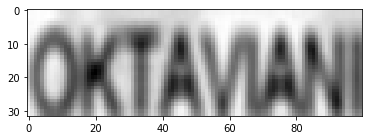

In [8]:
img, txt = trainset[20404]
plt.imshow(img.squeeze(), cmap='gray')
print(txt)

In [9]:
len(trainset), len(validset)

(2903797, 322776)

In [10]:
from iqra.utils import AttnLabelConverter
converter = AttnLabelConverter(CHARACTER)
num_class = len(converter.character)

In [11]:
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [12]:
imgs, texts =  next(iter(train_loader))

In [13]:
converter = AttnLabelConverter(CHARACTER)
NUM_CLASS = len(converter.character)

In [15]:
model = crnn_v1.OCRNet(num_class=NUM_CLASS, im_size=IMG_SIZE)
ocrnet_state_dict = torch.load('weights/ocrnet_pretrained_ktp.pth', map_location=torch.device('cpu'))
model.load_state_dict(ocrnet_state_dict)

model.freeze_spatial()
model.freeze_feature()
# model.freeze_sequence()


criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adadelta(model.parameters(), lr=LRATE, rho=RHO, eps=EPS)

In [16]:
checkpoint_path = 'checkpoints/'
# DEFAULTS used by the Trainer
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix='ocr_net_'
)

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /home/nunenuh/study/code/repo/crnn.pytorch exists and is not empty.
  warnings.warn(*args, **kwargs)


In [17]:
tb_logger = pl_loggers.TensorBoardLogger('logs/ocr_net')
task = OCRTaks(model, optimizer, criterion, converter)

In [23]:
task = task.load_from_checkpoint('../ocr_net_-checkpoints-v3.ckpt', 
                                 model=model, optimizer=optimizer, 
                                 criterion=criterion, converter=converter)


In [ ]:
trainer = pl.Trainer(max_epochs=3,
                     gpus=1, 
                     val_check_interval=10000,
                     logger=tb_logger, 
                     checkpoint_callback=checkpoint_callback)
trainer.fit(task, train_loader, valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | OCRNet           | 49.6 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
3.7 M     Trainable params
46.0 M    Non-trainable params
49.6 M    Total params


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Epoch 0:   6%|▌         | 10001/181527 [13:58<3:59:32, 11.93it/s, loss=0.00813, v_num=15, val_loss=6.5e-5, trn_loss=0.0262] 
Validating: 0it [00:00, ?it/s]
Validating:  19%|█▉        | 1946/10087 [04:40<19:13,  7.06it/s]

In [24]:
state_dict = task.model.state_dict()
ocrnet_path = 'weights/ocrnet_pretrained_ktp_v4.pth'
torch.save(state_dict, ocrnet_path)

In [25]:
ocrnet_path = 'weights/ocrnet_pretrained_ktp_v4.pth'
ocrnet_state_dict = torch.load(ocrnet_path, map_location=torch.device('cpu'))

model = crnn_v1.OCRNet(num_class=NUM_CLASS, im_size=IMG_SIZE)
model.load_state_dict(ocrnet_state_dict)

<All keys matched successfully>

In [26]:
from iqra.prod.prod import TextPredictor
ocrnet_path = 'weights/ocrnet_pretrained_ktp_v4.pth'
tp = TextPredictor(weight_path=ocrnet_path)

In [27]:
test_transform = VT.Compose([
    NT.ResizeRatioWithRightPad(size=IMG_SIZE),
#     VT.Grayscale(),
    VT.ToTensor(),
    VT.Normalize(mean=(0.5,), std=(0.5,))  
])

testset = LMDBDataset(root=val_path, 
                      transform=test_transform,
                       im_size=IMG_SIZE, 
                       is_sensitive=True,
                       character=CHARACTER)

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [28]:
imgs, texts = next(iter(test_loader))
outpred = tp.predict(imgs)

Pred: Gol. 	 Ground Truht: Gol.


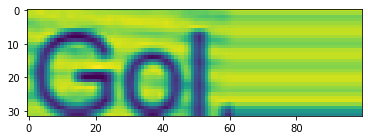

Pred: Alamat 	 Ground Truht: Alamat


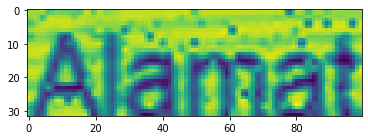

Pred: KARANGWARU 	 Ground Truht: KARANGWARU


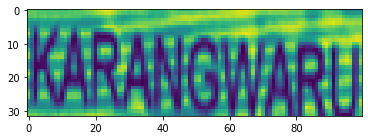

Pred: 011/000 	 Ground Truht: 015/008


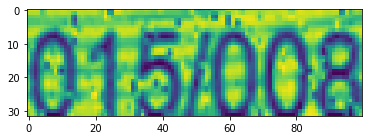

Pred: 004/016 	 Ground Truht: 004/016


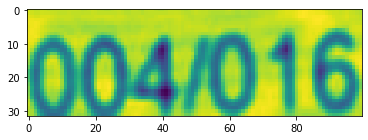

Pred: YOPITA 	 Ground Truht: YOPITA


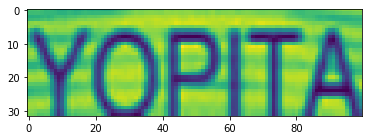

Pred: WNI 	 Ground Truht: WNI


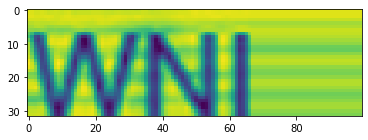

Pred: SAID 	 Ground Truht: SAID


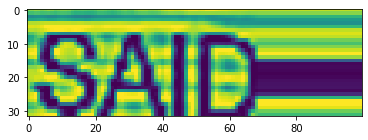

Pred: 0100008 	 Ground Truht: MEDOHO


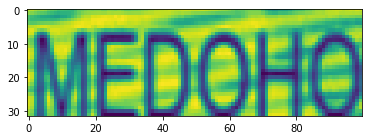

Pred: IRIADITO 	 Ground Truht: IRIANTO


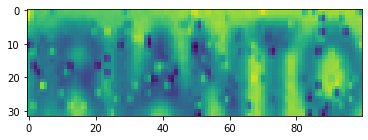

Pred: GAUSTA 	 Ground Truht: FAUSTA


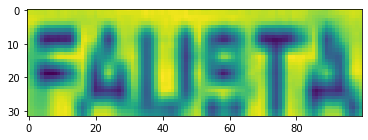

Pred: Kel/Desa 	 Ground Truht: Kel/Desa


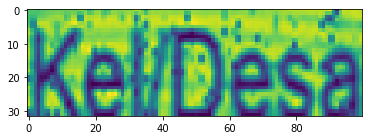

Pred: 025/012 	 Ground Truht: 025/012


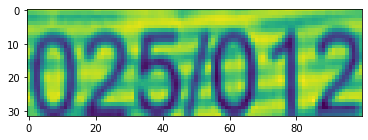

Pred: Nama 	 Ground Truht: Nama


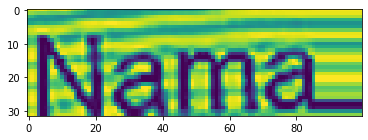

Pred: PETAJA/PENEBUNI 	 Ground Truht: PETANI/PEKEBUN


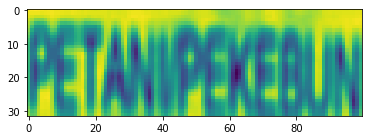

Pred: GLAGAH 	 Ground Truht: GLAGAH


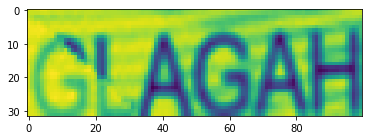

Pred: BAHACIS 	 Ground Truht: BAHAGIA


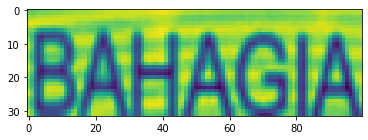

Pred: Jenis 	 Ground Truht: Jenis


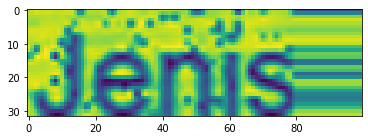

Pred: 25-09-2012 	 Ground Truht: 25-09-2012


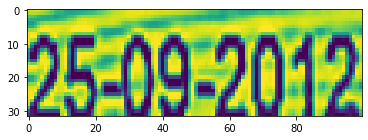

Pred: Kelamin 	 Ground Truht: Kelamin


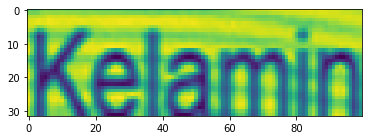

Pred: 12-04-2064 	 Ground Truht: PEKALONGAN


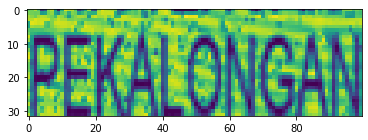

Pred: DABUAN 	 Ground Truht: DABUAN


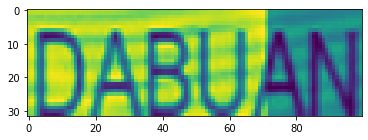

Pred: GARUT 	 Ground Truht: GARUT


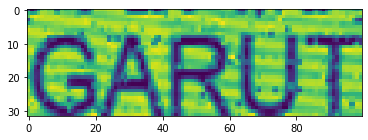

Pred: WNI 	 Ground Truht: WNI


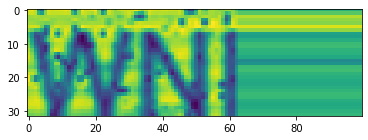

Pred: JAWA 	 Ground Truht: JAWA


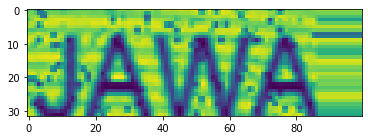

Pred: TUBAKOH 	 Ground Truht: TULAKAN


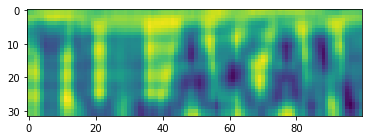

Pred: Alamat 	 Ground Truht: Alamat


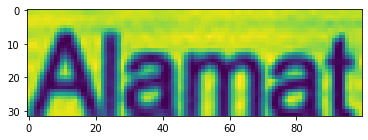

Pred: CAUSA 	 Ground Truht: CAUSA


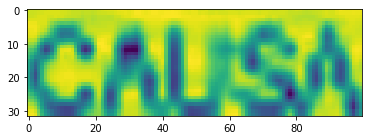

Pred: NUSA 	 Ground Truht: NUSA


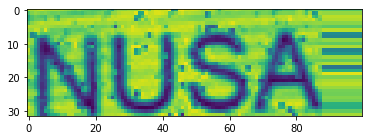

Pred: TENGAH 	 Ground Truht: TENGAH


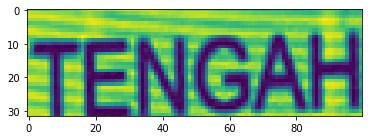

Pred: TENGGIPA 	 Ground Truht: TENGGARA


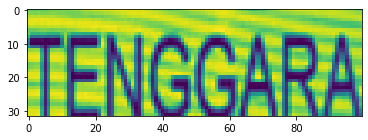

Pred: PUTRI 	 Ground Truht: PUTRI


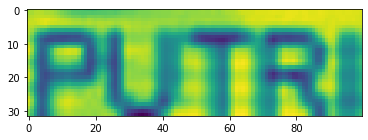

In [29]:
for (pr, gt, im) in zip(outpred, texts, imgs):
    print(f'Pred: {pr} \t Ground Truht: {gt}')    
    plt.imshow(im.squeeze());plt.show()
